## TODO


## Introduction: Injustice at Work

Our data source explores the relationship between attributes of the complainants/complaints regarding Employee Discrimination charges and the outcomes of each charge.

Due to working on our personal machines, we chose 25,000 rows of data at random to represent the full dataset. The original dataset can be found here: https://github.com/PublicI/employment-discrimination/blob/master/data/complaints_10.txt

According to the Injustice at Work Center, each attribute is defined as follows:

- Unique ID: unique identifier for each case (a case is a collection of related charges)
- State Code: complainant state
- No of Employees Code: code indicating the approximate number of employees working for respondent employer
- No of Employees: approximate number of employees working for respondent employer
- NAICS Code: North American Industry Classification System code of respondent employer
- NAICS Description: North American Industry Classification System description of respondent company (e.g., crude petroleum and natural gas extraction)
- Institution Type Code: classification code of respondent employer
- Institution Type: classification of respondent employer (e.g., private employer)
- CP Date of Birth: complainant’s date of birth
- CP Sex: complainant’s gender
- Date First Office: date charge was filed
- Date FEPA Sent to EEOC: date charge was forwarded to the EEOC
- Closure Date: date investigation of case was closed
- Closure Code: code indicating how case was closed
- Closure Type: description indicating how case was closed (e.g., no cause finding issued)
- Monetary Benefits: monetary benefit complainant received
- Statute Code: code for statute under which charge was filed
- Statute: statute under which charge was filed (e.g., Americans with Disabilities Act)
- Basis Code: code for basis of discrimination
- Basis: basis of discrimination (e.g., race-black/African American)
- Issue Code: type code for adverse action alleged by complainant
- Issue: adverse action alleged by complainant (e.g., harassment)
- Court Filing Date: date complainant filed a lawsuit
- Civil Action Number: case number of lawsuit
- Court: court in which lawsuit was filed
- Litigation Resolution Date: date lawsuit was resolved
- Litigation Monetary Benefits: monetary damages recovered through lawsuit
- Litigation Case Type: case type of lawsuit

Our analysis will be looking to classify data by "Closure Code"(? or type), and we have deduced that the possible predictive attributes are as follows:
- State Code: complainant state
- No of Employees Code: code indicating the approximate number of employees working for respondent employer
- NAICS Code: North American Industry Classification System code of respondent employer
- Institution Type Code: classification code of respondent employer
- CP Date of Birth: complainant’s date of birth *
- CP Sex: complainant’s gender
- Date First Office: date charge was filed *
- Date FEPA Sent to EEOC: date charge was forwarded to the EEOC *
- Basis Code: code for basis of discrimination
- Issue Code: type code for adverse action alleged by complainant
- Litigation Case Type: case type of lawsuit

## Grouping of Classes

In the full dataset, the feature closure_code had 13 possible codes that described the outcome of each complaint. We needed to group these into two distinct classes for the purposes of our data.  We grouped these 13 codes into representing class 0 (not in favor of complainant), class 1 (in favor of complainants), or belonging to neither of these classes because it did not end clearly in favor of either group. If the case did not end clearly in favor of the complainant or employer based on the content of the case (i.e legal reasons like no jurisdiction for EEOC, case filed outside of the correct time range, etc), we labelled this as class 3 and did not include the cases in our analysis. 

We determined this grouping by using the following guide to show explanations of the codes meaning: https://www.umass.edu/eeodatanet/sites/default/files/IMS%20Codes.pdf
Further explanation on terminology can be found here: https://www.eeoc.gov/eeoc/statistics/enforcement/definitions.cfm)

Class 0 (in favor of employer) codes: 
- M3 - No cause finding issued
- M5 - Conciliation failure
- X7 - Closed due to court decision

Class 1 (in favor of employee) codes:
- M1 - Withdrawal with benefits
- M2 - Settlement with Benefits
- M4 - Successful Conciliation
- X1 - CP Filed Suit

Codes that fit into neither category (class 3, but will be discarded for analysis):
- X3 - Respondent Bankruptcy
- X9 - ADEA Sect 7(D) Closure
- Y1 - No Jurisdiction
- N2 - NRTS issues at CP Request (a Right To Sue letter is issued when the agency cannot determine whether the employer discriminated against an employee)
- Y2 - CP Withdrawal - No benefits
- X2 - Administrative closure

## Pandas Settings

In [1]:
import pandas as pd

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)
pd.options.display.float_format = "{:,.2f}".format

## Preprocessing:
We are taking 25,000 rows from our dataset which included around 343,000 rows due to the limitations of doing this project on personal machines.

In [2]:
# code below was used to obtain a sample of 40,000 rows from the dataset.
'''
data = pd.read_csv("complaints_10.txt", sep="\t", skiprows=1,
                      dtype={1: str},
                      names=["unique_id", "state_code", "num_employee_code", "num_employees",
                             "naics_code", "naics_desc", "inst_type_code", "inst_type",
                             "birth_date", "sex", "date_filed", "date_sent_eeoc", "date_closed",
                             "closure_code", "closure_action", "monetary_benefits", "statute_code",
                             "statute", "basis_code", "basis", "issue_code", "issue",
                             "court_filing_date", "civil_action_num", "court", "resolution_date",
                             "litigation_monetary_benefits", "litigation_case_type"])

cols_to_drop = ['unique_id', 'num_employees', 'naics_desc', 
                'inst_type', 'date_closed', "closure_action",
                "monetary_benefits", "statute_code", "statute",
                "basis", "issue", "court_filing_date", "date_sent_eeoc",
                "civil_action_num", "court", "resolution_date",
                "litigation_monetary_benefits"
                ]

data = data.drop(cols_to_drop, axis = 1)
data = data.sample(n = 25_000)
data.to_csv('complaints_10-subset.csv', index=False)
'''
data = pd.read_csv('complaints_10-subset.csv')
data.head()

,state_code,num_employee_code,naics_code,inst_type_code,birth_date,sex,date_filed,closure_code,basis_code,issue_code,litigation_case_type
0,TX,C,nan,E,05/28/71,F,06/09/10,M3,GF,S5,NaN
1,NV,D,nan,E,04/18/66,NaN,05/11/10,M3,AC,D2,NaN
2,MA,NaN,"446,110.00",E,03/17/81,F,02/10/10,M3,OR,W1,NaN
3,PA,B,nan,G,07/18/56,F,11/03/09,M3,TP,T2,NaN
4,CA,A,nan,G,12/14/61,M,03/17/10,M3,VB,R6,NaN


Getting age from birth date and cleaning the age column

In [3]:
def get_age(dob, filing_date):
    if pd.isna(dob):
        return 0
    filing_year = int(str(filing_date)[-2:]) + 2000
    filing_year = filing_year if filing_year <= 2010 else og_year - 100
    birth_year = int(str(dob)[-2:]) + 2000
    birth_year = birth_year if birth_year <= 2010 else birth_year - 100
    age = filing_year - birth_year
    return age if age > 16 else 0

def get_year(date):
    if pd.isna(date):
        return 0
    og_year = int(str(date)[-2:]) + 2000
    year = og_year if og_year <= 2010 else og_year - 100
    og_year = year
    return og_year

data['age'] = data.apply(lambda x: get_age(x['birth_date'], x['date_filed']), axis=1)
data = data.drop(['birth_date'], axis = 1) 
data = data.drop(['date_filed'], axis = 1) 

Cleaning age field

In [4]:
from datetime import timedelta, date
import numpy as np

# Delete these row indexes from dataFrame. age is outlier
indexNames = data[ data['age'] >= 78 ].index
data.drop(indexNames , inplace=True)

data['age'] = data['age'].replace(0, np.nan) # to avoid counting in the zeroes
data['age'] = data['age'].replace(np.nan, data['age'].mean())

data.head()

,state_code,num_employee_code,naics_code,inst_type_code,sex,closure_code,basis_code,issue_code,litigation_case_type,age
0,TX,C,nan,E,F,M3,GF,S5,NaN,39.00
1,NV,D,nan,E,NaN,M3,AC,D2,NaN,44.00
2,MA,NaN,"446,110.00",E,F,M3,OR,W1,NaN,29.00
3,PA,B,nan,G,F,M3,TP,T2,NaN,53.00
4,CA,A,nan,G,M,M3,VB,R6,NaN,49.00


In [5]:
data["litigation_case_type"].fillna("No Litigation", inplace = True)
data["naics_code"].fillna(0.0, inplace = True)
data["state_code"].fillna(data["state_code"].mode()[0], inplace = True)
data["sex"].fillna(data["sex"].mode()[0], inplace = True)
data["num_employee_code"].fillna(data["num_employee_code"].mode()[0], inplace = True)
# drop rows with no basis_code OR no closure_code.
data = data.dropna()
data.isna().sum()

state_code              0
num_employee_code       0
naics_code              0
inst_type_code          0
sex                     0
closure_code            0
basis_code              0
issue_code              0
litigation_case_type    0
age                     0
dtype: int64

### Fix class label
Change values of closure code to their appropriate class of 0, 1, and 2 as described in "Grouping of Classes".

In [6]:
to_replace = {"M3" : 0, "M5" : 0, "X7" : 0, "M1" : 1, "M2" : 1, "M4" : 1, "X1" : 1, "X3" : 2, "X9" : 2, "Y1" : 2, "N2" : 2, "Y2" : 2, "X2" : 2}
data["closure_code"].replace(to_replace, inplace = True)
unusedClass = data[ data["closure_code"] == 2].index
data.drop(unusedClass , inplace=True)
data['closure_code'] = data['closure_code'].astype(int)

In [7]:
## Note for group: The groupings below are based only on the data present in the subset

### Fix "NAICS code" column
The important part of this code is the first three digits which indicates the sector and the subsector of the company.
More info on how to read NAICS codes: https://www.investopedia.com/terms/n/naics.asp

In [8]:
# get sector and subsector only
def extract_sector_and_subsector(naics_code):
    if naics_code == '0.0': # missing
        naics_code = "0"
        return "0"
    sector_subsector = naics_code[0:3] # first three digits
    naics_code = sector_subsector
    return naics_code
    
data["naics_code"] = data["naics_code"].astype(str)
data["naics_code"] = data["naics_code"].replace(",","")
data["naics_code"] = data["naics_code"].apply(extract_sector_and_subsector)
data["naics_code"] = data["naics_code"].astype(int) # convert to int. faster to work with
# data["naics_code"].replace({0: np.nan}, inplace = True) # uncomment if needed
data.head()

,state_code,num_employee_code,naics_code,inst_type_code,sex,closure_code,basis_code,issue_code,litigation_case_type,age
0,TX,C,0,E,F,0,GF,S5,No Litigation,39.00
1,NV,D,0,E,F,0,AC,D2,No Litigation,44.00
2,MA,D,446,E,F,0,OR,W1,No Litigation,29.00
3,PA,B,0,G,F,0,TP,T2,No Litigation,53.00
4,CA,A,0,G,M,0,VB,R6,No Litigation,49.00


### Fix "Basis Code" column
When looking at how the basis of discrimination allegations were grouped by Statue code, we were unsatisfied by how broad the categories were. However, including each individual basis would have increased the dimensionality of our dataset too greatly; therefore, we decided to group each basis into our own categories as follows:

#### Race:
- RB: Race-Black/African American
- RW: Race-White
- OC: Color
- RS: Race-Asian
- RM: RM Race-Bi-Racial/Multi-Racial
- RI: Race-American Indian/Alaska Native
- RH: Race-Native Hawaiian/Pacific Islander
- RO: Race-Other - Obsolete

#### National Origin:
- NH: National Origin-Hispanic
- NO: National Origin-Other
- NM: National Origin-Mexican
- NE: National Origin-East Indian
- FB: Ancestry

#### Religion:
- AO: Religion-Other
- AM: Religion-Muslim
- AJ: Religion-Jewish
- AP: Religion-Protestant
- AC: Religion-Catholic
- AA: Religion-7th Day Adventist
- AS: Religion-Sikhs

#### Age:
- OA: Age

#### Physical Health:
- Z2: Other Disability
- Z3: Record Of Disability
- Z4: Regarded as Disabled
- VB: Nonparalytic Orthopedic Impairment
- T3: Orthopedic/Structural Back Impairment
- U2: Diabetes
- W3: Heart/Cardiovascular
- U1: Cancer
- W2: Hearing Impairment
- Z1: Vision Impairment
- WJ: Multiple Sclerosis
- T2: Asthma
- XC: Other Pulmo/Respiratory
- WG: Epilepsy
- W1: Gastrointestinal
- WD: Brain/Head Injury (Traumatic)
- TP: Blood (Other)
- T1: Allergies
- TN: HIV
- W4: Kidney Impairment
- T7: Genetic Information Discrimination (GINA Only)
- OH: Handicap (Not ADA)
- VA: Missing Digits/Limbs
- WK: Paralysis
- Y1: Speech Impairment
- WE: Cerebral Palsy
- T4: Chemical Sensitivity
- WF: Cumulative Trauma Disorder
- U4: Dwarfism
- U3: Disfigurement
- XA: Cystic Fibrosis
- Z6: Genetic Discrimination (ADA Only)
- XB: Tuberculosis

#### Mental Health:
- UB: Depression
- UA: Other Anxiety Disorder
- UL: Other Neurological
- UC: Manic Depression (Bi-polar)
- WH: Learning Disability
- U6: Post-Traumatic Stress Disorder
- UE: Other Psychiatric Disorders
- YB: Drug Addiction
- UD: Schizophrenia
- YA: Alcoholism
- W5: Mental Retardation
- WA: Autism
- WC: Alzheimers

#### Gender:
- GF: Sex-Female
- GM: Sex-Male
- GP: Sex-Pregnancy
- PF: Equal Pay-Female
- PM: Equal Pay-Male

#### Retaliation:
- OR: Retaliation

#### Other:
- OO: Other
- Z5: Relationship/Assn.



In [9]:
basis_grouping = {}
basis_grouping.update(dict.fromkeys(["RB", "RW", "OC", "RS", "RM", "RI", "RH", "RO"], "Race"))
basis_grouping.update(dict.fromkeys(["NH", "NO", "NM", "NE", "FB"], "National Origin"))
basis_grouping.update(dict.fromkeys(["AO", "AM", "AJ", "AP", "AC", "AA", "AS"], "Religion"))
basis_grouping.update(dict.fromkeys(["OA"], "Age"))
basis_grouping.update(dict.fromkeys(["Z2", "Z3", "Z4", "VB", "T3", "U2", "W3", "U1", "W2", "Z1", "WJ", "T2", "XC", "WG", "W1", "WD", "TP", "T1", "TN", "W4", "T7", "OH", "VA", "WK", "Y1", "WE", "T4", "WF", "U4", "U3", "XA", "Z6", "XB"], "Physical Health"))
basis_grouping.update(dict.fromkeys(["UB", "UA", "UL", "UC", "WH", "U6", "UE", "YB", "UD", "YA", "W5", "WA", "WC"], "Mental Health"))
basis_grouping.update(dict.fromkeys(["GF", "GM", "GP", "PF", "PM"], "Gender"))
basis_grouping.update(dict.fromkeys(["OR"], "Retaliation"))
basis_grouping.update(dict.fromkeys(["OO", "Z5"], "Other"))

data["basis_code"].replace(basis_grouping, inplace = True)

data.head()

,state_code,num_employee_code,naics_code,inst_type_code,sex,closure_code,basis_code,issue_code,litigation_case_type,age
0,TX,C,0,E,F,0,Gender,S5,No Litigation,39.00
1,NV,D,0,E,F,0,Religion,D2,No Litigation,44.00
2,MA,D,446,E,F,0,Retaliation,W1,No Litigation,29.00
3,PA,B,0,G,F,0,Physical Health,T2,No Litigation,53.00
4,CA,A,0,G,M,0,Physical Health,R6,No Litigation,49.00


### Fix "Issue Code" column
Including each individual basis would have increased the dimensionality of our dataset too greatly; therefore, we decided to group each ISSUE into our own categories as follows:

#### Suspension/Layoff:
- S5: Suspension
- D2: Discharge
- L1: Layoff
- C1: Constructive Discharge
- R5: Retirement-Involuntary

#### Monetary:
- W1: Wages
- B2: Benefits-Retirement/Pension
- B5: Severance Pay Denied
- B1: Benefits
- B6: Early Retirement Incentive


#### Hiring/Status:
- H2: Hiring
- P3: Promotion
- T1: Tenure
- R4: Reinstatement
- A3: Assignment
- R2: References Unfavorable
- T4: Training
- S3: Seniority
- A2: Apprenticeship
- R3: Referral
- Q1: Qualifications
- J1: Job Classification 
- D1: Demotion


#### Workers Rights:
- U1: Union Representation
- F1: Filing EEO Forms
- R6: Reasonable Accomodation
- P5: Posting Notices
- P6: Breach of Confidentiality
- P4: Prohibited Medical Inquiry/Exam
- B3: Benefits-Insurance
- T3: Testing
- B4: Waivers

#### Exclusion:
- L3: Other Language/Accent Issue
- L2: English Language Only Rule
- E1: Exclusion
- S1: Segregated Facilities
- M1: Maternity

#### Harassment:
- H1: Harassment
- S4: Sexual Harassment
- I1: Intimidation


#### Other: 
- O1: Other
- T2: Terms/Conditions
- R7: Record Keeping Violation (???)
- D3: Discipline (???)
- R1: Recall (???)

In [10]:
issue_grouping = {}
issue_grouping.update(dict.fromkeys(["S5", "D2", "L1", "C1", "R5"], "Suspension/Layoff"))
issue_grouping.update(dict.fromkeys(["W1", "B2", "B5", "B1", "B6"], "Monetary"))
issue_grouping.update(dict.fromkeys(["H2", "P3", "T1", "R4", "A3", "R2", "T4", "S3", "A2", "R3", "Q1", "J1", "D1"], "Hiring/Status"))
issue_grouping.update(dict.fromkeys(["U1", "F1", "R6", "P5", "P6", "P4", "B3", "T3", "B4"], "Workers Rights"))
issue_grouping.update(dict.fromkeys(["L3", "L2", "E1", "S1", "M1"], "Exclusion"))
issue_grouping.update(dict.fromkeys(["H1", "S4"], "Harassment"))
issue_grouping.update(dict.fromkeys(["O1", "T2", "R7", "R1", "D3"], "Other"))

data["issue_code"].replace(issue_grouping, inplace = True)

data.head()

,state_code,num_employee_code,naics_code,inst_type_code,sex,closure_code,basis_code,issue_code,litigation_case_type,age
0,TX,C,0,E,F,0,Gender,Suspension/Layoff,No Litigation,39.00
1,NV,D,0,E,F,0,Religion,Suspension/Layoff,No Litigation,44.00
2,MA,D,446,E,F,0,Retaliation,Monetary,No Litigation,29.00
3,PA,B,0,G,F,0,Physical Health,Other,No Litigation,53.00
4,CA,A,0,G,M,0,Physical Health,Workers Rights,No Litigation,49.00


### Separating the class label from features

In [11]:
labels = data['closure_code']
labels_flat = labels.values.ravel() # to use later
features = data.drop(['closure_code'],axis=1)

# Model Training

## Decision Tree Classifier
Decision Tree classifier gives us an average accurace of around %75.

In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV



def convert(data):
    number = preprocessing.LabelEncoder()
    data['state_code'] = number.fit_transform(data.state_code)
    data['num_employee_code'] = number.fit_transform(data.num_employee_code)
    data['naics_code'] = number.fit_transform(data.naics_code)
    data['inst_type_code'] = number.fit_transform(data.inst_type_code)
    data['sex'] = number.fit_transform(data.sex)
    data['basis_code'] = number.fit_transform(data.basis_code)
    data['issue_code'] = number.fit_transform(data.issue_code)
    data['litigation_case_type'] = number.fit_transform(data.litigation_case_type)
    data=data.fillna(-999)
    return data


features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20)
features_train = convert(features_train)
features_test = convert(features_test)
assert features_train.shape[0] == labels_train.shape[0]
assert features_test.shape[0] == labels_test.shape[0]
print("Train Size:", features_train.shape[0])
print("Test Size:", features_test.shape[0])

numerical_features = convert(features)

'''
We tested the model with the following hyper-parameters:
    - max_depth: range(5, 50)
    - min_samples_leaf: range(5, 50)
    - max_features": range(1, 9)
    
it took around 30 minutes and we got the following:
    Best params: {'max_depth': 5, 'max_features': 6, 'min_samples_leaf': 32}
    
For the sake of runtime, we changed the parameters below in case we need to
run this again
'''

clf = DecisionTreeClassifier()
params = {
    # [5, 6, 7, 8,9, 10, 11]
    "max_depth": [5, 10, 15],
    "min_samples_leaf": [16, 32, 48],
    "max_features": [6, 7, 8, 9]
}

grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy')
grid_search.fit(numerical_features, labels)
print("Best params: ")
print(grid_search.best_params_) 
print("\nBest Accuracy: ")
print(grid_search.best_score_*100)

nested_score = cross_val_score(grid_search, numerical_features, labels, cv=5)
print("*** Final Accuracy ***")
print("Accuracy:", nested_score.mean()*100)

/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

Train Size: 10792
Test Size: 2699
Best params: 
{'max_depth': 5, 'max_features': 7, 'min_samples_leaf': 48}

Best Accuracy: 
75.19828473385112
*** Final Accuracy ***
Accuracy: 75.05002401845013


## Naive Bayes Classifier
Naive Bayes gives us an average accuracy of %26 accross all 10 folds which was expected given the strong correlation between our features.

Average of all folds:
26.825335639568404
Confusion Matrix: 
[[ 339 9799]
 [  73 3280]]
AUC Score: 
55.72208896609906


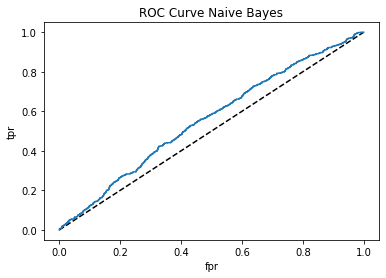

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

nb_clf = GaussianNB()
nb_clf_score = cross_val_score(nb_clf, features, labels, cv=10)
print("Average of all folds:")
print(np.average(nb_clf_score) * 100)

predictions = cross_val_predict(nb_clf, features, labels, cv = 10)  
conf_matrix = confusion_matrix(labels, predictions)
print("Confusion Matrix: ")
print(str(conf_matrix))


nb_clf.fit(features_train, labels_train)
predict_probas = nb_clf.predict_proba(features_test)

fpr, tpr, thresholds = roc_curve(labels_test, predict_probas[:,1])
auc_score = roc_auc_score(labels_test, predict_probas[:,1])
print("AUC Score: ")
print(auc_score * 100)

plt.plot([0,1],[0,1],'k--') #plot the diagonal line
plt.plot(fpr, tpr, label='NB') #plot the ROC curve
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve Naive Bayes')
plt.show()

## KNN Classifier

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

scaler = StandardScaler(with_mean=True, with_std=True)
decomp_pca = PCA()
knn_clf = KNeighborsClassifier()
pipeline = Pipeline(steps=[('scaler', scaler), ('pca', decomp_pca), ('knn', knn_clf)])


param_grid = {
    'pca__n_components': list(range(2, 5)),
    'knn__n_neighbors': [14, 19, 24]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(features, labels)
print("Best params: ")
print(grid_search.best_params_) 
print("\nBest Accuracy: ")
print(grid_search.best_score_*100)

Best params: 
{'knn__n_neighbors': 24, 'pca__n_components': 2}

Best Accuracy: 
75.00556585353661


## SVM Classifier

In [15]:
from sklearn.svm import SVC

svc = SVC()
pipeline = Pipeline(steps=[('scaler', scaler), ('pca', decomp_pca), ('svm', svc)])
param_grid = {
    'pca__n_components': list(range(2, 5)),
    'svm__kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(features, labels)
print("Best params: ")
print(grid_search.best_params_) 
predictions = cross_val_predict(grid_search, features, labels, cv = 5)
report = classification_report(labels, predictions, output_dict = True)
print("Accuracy: ")
print(str(report['accuracy']*100))
print("\n\nClassification Report: ")
report

Best params: 
{'pca__n_components': 2, 'svm__kernel': 'linear'}
Accuracy: 
75.14639389222445


Classification Report: 


/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'precision': 0.7514639389222445,
  'recall': 1.0,
  'f1-score': 0.8580980997926276,
  'support': 10138},
 '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3353},
 'accuracy': 0.7514639389222445,
 'macro avg': {'precision': 0.37573196946112225,
  'recall': 0.5,
  'f1-score': 0.4290490498963138,
  'support': 13491},
 'weighted avg': {'precision': 0.5646980515005348,
  'recall': 0.7514639389222445,
  'f1-score': 0.6448297780518611,
  'support': 13491}}

## MLP Classifier (Nueral Nets)

In [18]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

pipeline = Pipeline(steps=[('scaler', scaler), ('mlp', mlp)])
param_grid = {
    'mlp__hidden_layer_sizes': list(range(30, 60, 10)),
    'mlp__activation': ["logistic", "tanh", "relu"]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(features, labels)
print("Best params: ")
print(grid_search.best_params_) 
predictions = cross_val_score(grid_search, features, labels, cv=5)
print(predictions.mean()*100)

/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations 

Best params: 
{'mlp__activation': 'logistic', 'mlp__hidden_layer_sizes': 30}


/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations 

/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations 

/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations 

/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/amirgamenet/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations 

75.1389815463048


## Ensemble Classifier - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

param_grid = {
    'max_depth': list(range(35,55)),
    'min_samples_leaf': [8, 10, 12],
    'max_features': ["sqrt", "log2"]
}

grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(features, labels)
predictions = cross_val_score(grid_search, features, labels, cv=5)
print(predictions.mean()*100)

## Ensemble Classifier - ADA Boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada_boost = AdaBoostClassifier(n_estimators = 150)
predictions = cross_val_score(ada_boost, features, labels, cv=5)
print(predictions.mean()*100)

# Final Model

In [ ]:
import pickle
'''
svc = SVC()
pipeline = Pipeline(steps=[('scaler', scaler), ('pca', decomp_pca), ('svm', svc)])
param_grid = {
    'pca__n_components': list(range(5, 19)),
    'svm__kernel': ['linear', 'rbf', 'poly']
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(features, labels)
print("Best params: ")
print(grid_search.best_params_) 
print("\nBest Accuracy: ")
print(grid_search.best_score_*100) 
#replace this final_model with your final model
final_model = grid_search
filename = 'finalized_model.sav'
pickle.dump(final_model, open(filename, 'wb'))
'''